In [69]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
import random
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from scipy.sparse import hstack
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image


**Extract Images**

In [44]:
!apt-get install -y p7zip-full

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.


In [45]:


MERGED_FOLDER = "/content/merged_imgs"
os.makedirs(MERGED_FOLDER, exist_ok=True)

# Extract ZIP files
for f in os.listdir("/content"):
    if f.endswith(".zip"):
        zip_path = os.path.join("/content", f)
        print(f"Extracting {zip_path} ...")
        os.system(f"unzip -q {zip_path} -d {MERGED_FOLDER}")

# Extract 7z files
for f in os.listdir("/content"):
    if f.endswith(".7z"):
        sevenz_path = os.path.join("/content", f)
        print(f"Extracting {sevenz_path} ...")
        os.system(f"7z x {sevenz_path} -o{MERGED_FOLDER} -y")

print("✅ All archives extracted to /content/merged_imgs")

Extracting /content/bones.zip ...
Extracting /content/neck.zip ...
Extracting /content/dental.zip ...
Extracting /content/chest.zip ...
Extracting /content/knee.zip ...
✅ All archives extracted to /content/merged_imgs


In [46]:
!ls /content/merged_imgs

bones  chest  dental  knee  neck


In [47]:


SOURCE = "/content/merged_imgs"
DEST = "/content/dataset"
os.makedirs(DEST, exist_ok=True)

for organ in os.listdir(SOURCE):
    organ_path = os.path.join(SOURCE, organ)
    if not os.path.isdir(organ_path):
        continue

    for label in os.listdir(organ_path):
        label_path = os.path.join(organ_path, label)
        if not os.path.isdir(label_path):
            continue

        class_name = f"{organ}_{label}"
        class_dir = os.path.join(DEST, class_name)
        os.makedirs(class_dir, exist_ok=True)

        for img in os.listdir(label_path):
            shutil.copy(os.path.join(label_path, img), os.path.join(class_dir, img))

print("✅ Dataset prepared for CNN")

✅ Dataset prepared for CNN


In [48]:

print("Folders in dataset:")
for cls in os.listdir(DEST):
    n = len(os.listdir(os.path.join(DEST, cls)))
    print(f"{cls}: {n} images")


Folders in dataset:
bones_Fractured: 780 images
knee_normal: 220 images
dental_normal: 223 images
chest_normal: 352 images
knee_not normal: 236 images
neck_normal: 71 images
chest_not normal: 554 images
dental_not normal: 173 images
neck_not normal: 267 images
bones_Non-Fractured: 1740 images


**Text preprocessing**

In [11]:
df = pd.read_csv("noisy_medical_data.csv")

df.head()
df.info()
df.isnull().sum()
df["Label"].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID            500 non-null    int64 
 1   Opinion       500 non-null    object
 2   Source        500 non-null    object
 3   DiseaseLabel  500 non-null    object
 4   Label         500 non-null    object
dtypes: int64(1), object(4)
memory usage: 19.7+ KB


,count
Label,
Incorrect,258
Correct,242


In [12]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["clean_Opinion"] = df["Opinion"].apply(clean_text)


In [13]:


X = df["clean_Opinion"]
y = df["Label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [14]:


tfidf = TfidfVectorizer(
    ngram_range=(1, 2),
    stop_words="english",
    max_features=5000
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


**LogisticRegression**

In [15]:


lr_model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced"
)

lr_model.fit(X_train_tfidf, y_train)
y_pred_lr = lr_model.predict(X_test_tfidf)

print(classification_report(y_test, y_pred_lr))


              precision    recall  f1-score   support

     Correct       0.82      0.85      0.84        48
   Incorrect       0.86      0.83      0.84        52

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100



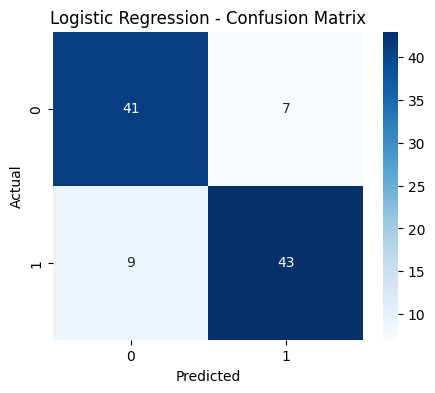

In [16]:
cm = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


**SVM**

In [17]:

svm_model = SVC(kernel="linear", probability=True)

svm_model.fit(X_train_tfidf, y_train)
y_pred_svm = svm_model.predict(X_test_tfidf)

print(classification_report(y_test, y_pred_svm))


              precision    recall  f1-score   support

     Correct       0.82      0.85      0.84        48
   Incorrect       0.86      0.83      0.84        52

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100



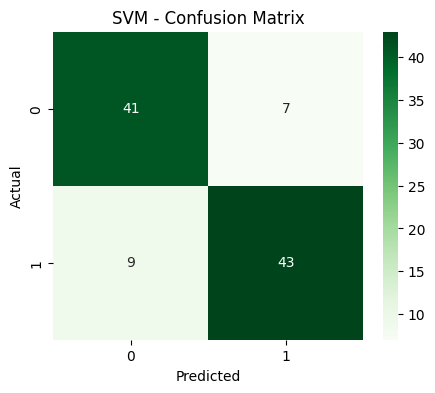

In [18]:
cm = confusion_matrix(y_test, y_pred_svm)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
plt.title("SVM - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


**Naive Bayes**

In [19]:


nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

y_pred_nb = nb_model.predict(X_test_tfidf)

print(classification_report(y_test, y_pred_nb))


              precision    recall  f1-score   support

     Correct       0.82      0.85      0.84        48
   Incorrect       0.86      0.83      0.84        52

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100



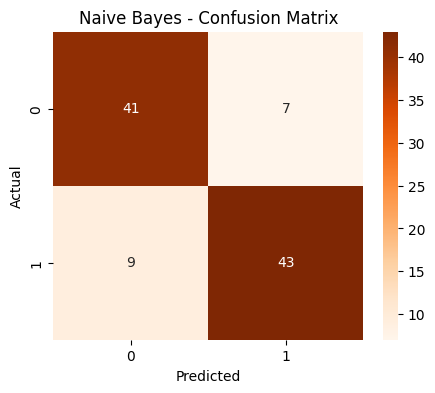

In [20]:
cm = confusion_matrix(y_test, y_pred_nb)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges")
plt.title("Naive Bayes - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [23]:

source_encoder = LabelEncoder()
disease_encoder = LabelEncoder()
label_encoder = LabelEncoder()

y_encoded = label_encoder.fit_transform(df["Label"])

X_source = source_encoder.fit_transform(df["Source"]).reshape(-1,1)
X_disease = disease_encoder.fit_transform(df["DiseaseLabel"]).reshape(-1,1)

X_text_tfidf = tfidf.fit_transform(df["clean_Opinion"])

X_final = hstack([X_text_tfidf, X_source, X_disease])


**RandomForest**

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_encoded,
    test_size=0.2,
    stratify=y_encoded,
    random_state=42
)

rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print(classification_report(
    y_test, y_pred_rf,
    target_names=label_encoder.classes_
))


              precision    recall  f1-score   support

     Correct       0.77      0.77      0.77        48
   Incorrect       0.79      0.79      0.79        52

    accuracy                           0.78       100
   macro avg       0.78      0.78      0.78       100
weighted avg       0.78      0.78      0.78       100



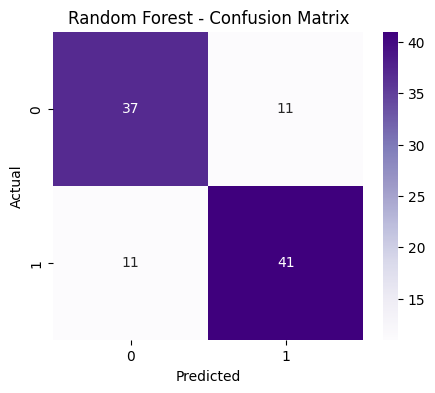

In [25]:
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples")
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


**CNN**

In [50]:


print("Folders in dataset:")
for cls in os.listdir(DEST):
    n = len(os.listdir(os.path.join(DEST, cls)))
    print(f"{cls}: {n} images")

Folders in dataset:
bones_Fractured: 780 images
knee_normal: 220 images
dental_normal: 223 images
chest_normal: 352 images
knee_not normal: 236 images
neck_normal: 71 images
chest_not normal: 554 images
dental_not normal: 173 images
neck_not normal: 267 images
bones_Non-Fractured: 1740 images


In [51]:


SRC = DEST
TRAIN_DIR = "/content/train"
VAL_DIR = "/content/val"
VAL_SPLIT = 0.2  # 20% validation

os.makedirs(TRAIN_DIR, exist_ok=True)
os.makedirs(VAL_DIR, exist_ok=True)

for cls in os.listdir(SRC):
    class_path = os.path.join(SRC, cls)
    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    random.shuffle(images)
    split_idx = int(len(images) * VAL_SPLIT)

    # Create class folders in train and val
    train_class_dir = os.path.join(TRAIN_DIR, cls)
    val_class_dir = os.path.join(VAL_DIR, cls)
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(val_class_dir, exist_ok=True)

    for i, img in enumerate(images):
        src_path = os.path.join(class_path, img)
        if i < split_idx:
            shutil.copy(src_path, os.path.join(val_class_dir, img))
        else:
            shutil.copy(src_path, os.path.join(train_class_dir, img))

print("✅ Train/Validation split done")

✅ Train/Validation split done


In [52]:

print("Train folder structure:")
for cls in os.listdir(TRAIN_DIR):
    n = len(os.listdir(os.path.join(TRAIN_DIR, cls)))
    print(f"{cls}: {n} images")

print("\nValidation folder structure:")
for cls in os.listdir(VAL_DIR):
    n = len(os.listdir(os.path.join(VAL_DIR, cls)))
    print(f"{cls}: {n} images")

Train folder structure:
bones_Fractured: 624 images
knee_normal: 176 images
dental_normal: 179 images
chest_normal: 282 images
knee_not normal: 189 images
neck_normal: 57 images
chest_not normal: 444 images
dental_not normal: 139 images
neck_not normal: 214 images
bones_Non-Fractured: 1392 images

Validation folder structure:
bones_Fractured: 156 images
knee_normal: 44 images
dental_normal: 44 images
chest_normal: 70 images
knee_not normal: 47 images
neck_normal: 14 images
chest_not normal: 110 images
dental_not normal: 34 images
neck_not normal: 53 images
bones_Non-Fractured: 348 images


In [53]:
IMG_SIZE = 64
BATCH_SIZE = 32
EPOCHS = 10

train_gen = ImageDataGenerator(rescale=1./255)
val_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    "/content/train",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_data = val_gen.flow_from_directory(
    "/content/val",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)


Found 3696 images belonging to 10 classes.
Found 920 images belonging to 10 classes.


In [54]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(64, activation='relu'),
    Dense(train_data.num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


Epoch 1/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 31s 238ms/step - accuracy: 0.5441 - loss: 1.3134 - val_accuracy: 0.7304 - val_loss: 0.6273
Epoch 2/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 27s 235ms/step - accuracy: 0.7536 - loss: 0.5270 - val_accuracy: 0.7576 - val_loss: 0.5200
Epoch 3/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 28s 240ms/step - accuracy: 0.7823 - loss: 0.4596 - val_accuracy: 0.7500 - val_loss: 0.5089
Epoch 4/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 29s 248ms/step - accuracy: 0.8056 - loss: 0.4171 - val_accuracy: 0.7717 - val_loss: 0.4588
Epoch 5/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 30s 256ms/step - accuracy: 0.8309 - loss: 0.3610 - val_accuracy: 0.7717 - val_loss: 0.4518
Epoch 6/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 27s 236ms/step - accuracy: 0.8591 - loss: 0.3233 - val_accuracy: 0.7772 - val_loss: 0.4832
Epoch 7/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 30s 261ms/step - accuracy: 0.8666 - loss: 0.3036 - val_accuracy: 0.7913 - val_loss: 0.4681
Epoch 8/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 38s 235ms/step - accuracy: 0.8916 - loss: 0

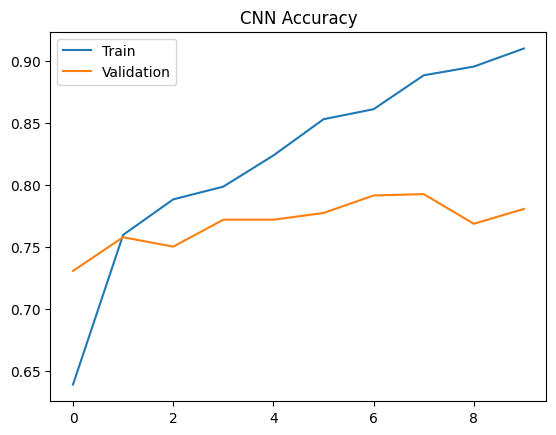

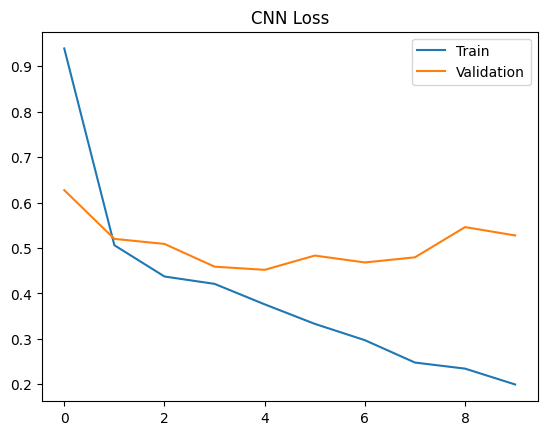

In [55]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS
)

plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title("CNN Accuracy")
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("CNN Loss")
plt.legend()
plt.show()


**TEST FOR CNN**

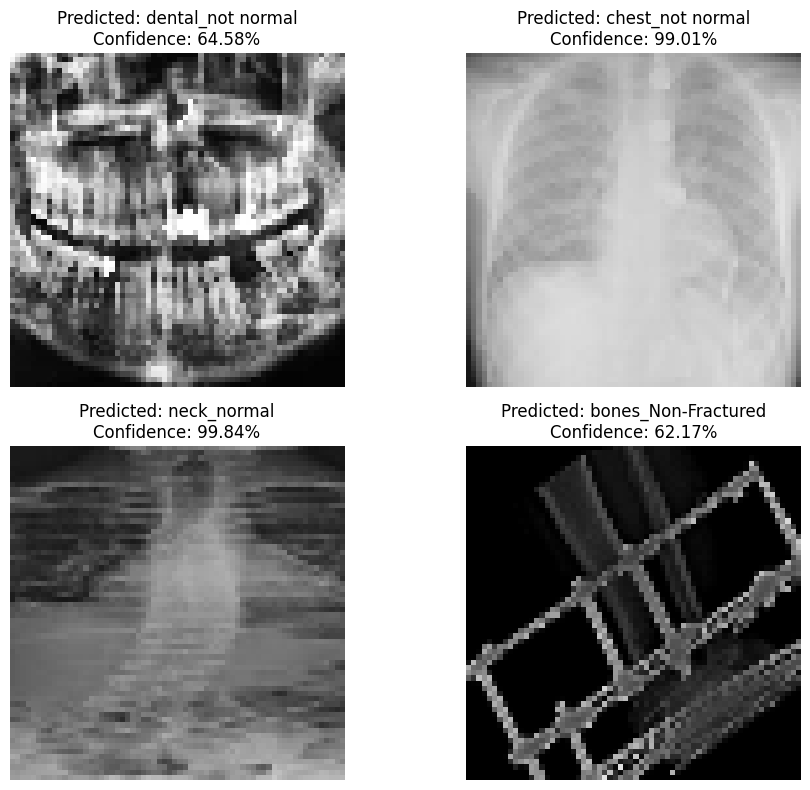

In [57]:


# 🔹 Put paths of 4 images here (change names if needed)
image_paths = [
    "/content/val/11.jpg",
    "/content/val/TB.107.jpg",
    "/content/val/N17,N,M,19_1_0.jpg",
    "/content/val/Fractured (101)_aug_1.jpg"
]

class_names = list(train_data.class_indices.keys())

plt.figure(figsize=(10,8))

for i, img_path in enumerate(image_paths):
    # Load & preprocess image
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    pred = model.predict(img_array, verbose=0)
    pred_class = np.argmax(pred, axis=1)[0]
    confidence = np.max(pred) * 100

    # Plot
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(
        f"Predicted: {class_names[pred_class]}\n"
        f"Confidence: {confidence:.2f}%"
    )

plt.tight_layout()
plt.show()


**Decision-Level Fusion**

In [59]:
# Logistic Regression probabilities on test text
lr_probs = lr_model.predict_proba(X_test_tfidf)

# Map label index
lr_classes = lr_model.classes_
print(lr_classes)


['Correct' 'Incorrect']


In [60]:
p_text_correct = lr_probs[:, list(lr_classes).index("Correct")]


In [61]:
cnn_probs = model.predict(val_data)


29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step


In [62]:
class_names = list(train_data.class_indices.keys())

abnormal_indices = [
    i for i, name in enumerate(class_names)
    if ("not_normal" in name.lower()) or ("fractured" in name.lower())
]


In [63]:
p_image_abnormal = cnn_probs[:, abnormal_indices].sum(axis=1)
p_image_normal = 1 - p_image_abnormal


In [64]:
min_len = min(len(p_text_correct), len(p_image_abnormal))

p_text_correct = p_text_correct[:min_len]
p_image_abnormal = p_image_abnormal[:min_len]


In [65]:
alpha = 0.5  # text importance
beta = 0.5   # image importance


In [66]:
fusion_score = alpha * p_text_correct + beta * p_image_abnormal
fusion_pred = np.where(fusion_score >= 0.5, "Correct", "Incorrect")


In [67]:
fusion_df = pd.DataFrame({
    "Text_Prob_Correct": p_text_correct,
    "Image_Prob_Abnormal": p_image_abnormal,
    "Fusion_Score": fusion_score,
    "Fusion_Prediction": fusion_pred
})

fusion_df.head()


,Text_Prob_Correct,Image_Prob_Abnormal,Fusion_Score,Fusion_Prediction
0,0.216837,4.347303e-10,0.108418,Incorrect
1,0.279626,4.506619e-10,0.139813,Incorrect
2,0.606048,9.336278e-08,0.303024,Incorrect
3,0.175185,5.203477e-08,0.087592,Incorrect
4,0.814259,1.452495e-04,0.407202,Incorrect


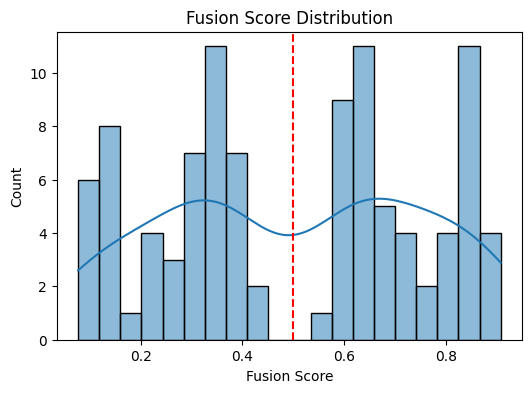

In [68]:
plt.figure(figsize=(6,4))
sns.histplot(fusion_score, bins=20, kde=True)
plt.axvline(0.5, color="red", linestyle="--")
plt.title("Fusion Score Distribution")
plt.xlabel("Fusion Score")
plt.show()
